<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#HyperSpy-Fitting-tutorial" data-toc-modified-id="HyperSpy-Fitting-tutorial-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>HyperSpy Fitting tutorial</a></span><ul class="toc-item"><li><span><a href="#Author:" data-toc-modified-id="Author:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Author:</a></span><ul class="toc-item"><li><span><a href="#Terminology-and-relationships" data-toc-modified-id="Terminology-and-relationships-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Terminology and relationships</a></span></li></ul></li></ul></li><li><span><a href="#Generating-synthetic-data" data-toc-modified-id="Generating-synthetic-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generating synthetic data</a></span><ul class="toc-item"><li><span><a href="#Two-peaks" data-toc-modified-id="Two-peaks-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Two peaks</a></span></li><li><span><a href="#Wobbly-peak" data-toc-modified-id="Wobbly-peak-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Wobbly peak</a></span><ul class="toc-item"><li><span><a href="#Importing" data-toc-modified-id="Importing-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Importing</a></span></li><li><span><a href="#How-do-I-....-again?" data-toc-modified-id="How-do-I-....-again?-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>How do I .... again?</a></span></li><li><span><a href="#Fitting-in-HyperSpy-(detailed)" data-toc-modified-id="Fitting-in-HyperSpy-(detailed)-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Fitting in HyperSpy (detailed)</a></span></li></ul></li><li><span><a href="#Fitting-multi-dimensional-signals" data-toc-modified-id="Fitting-multi-dimensional-signals-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Fitting multi-dimensional signals</a></span></li><li><span><a href="#Goodness-of-fit" data-toc-modified-id="Goodness-of-fit-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Goodness of fit</a></span></li><li><span><a href="#Defining-your-own-components" data-toc-modified-id="Defining-your-own-components-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Defining your own components</a></span></li></ul></li></ul></div>

# HyperSpy Fitting tutorial

This tutorial shows the basics of model (currently only 1D) fitting in HyperSpy from the grounds up. All data is artificial and can be generated by running the code <a href='#two_peaks'>at the end</a> of the notebook.

__Required version:__

    HyperSpy 1.3

## Author:

* 25/04/2017 Francisco de la Peña - Updated it for Diamond Light Source workshop
  * Fix TOC and internal links
  * Redifine the ``sin`` component to facilite setting the initial parameters
* 13/04/2015 Tomas Ostasevicius - Developed for HyperSpy workshop at University of Cambridge
* 01/06/2016 Tomas Ostasevicius - updated and expanded for HyperSpy workshop at Scandem conference 2016
* 22/07/2016 Tomas Ostasevicius - updated for HyperSpy version 1.0

<a id='terms'></a>
### Terminology and relationships
[Go to TOC](#Table-of-Contents)

In order to use fitting in HyperSpy more effectively, it is useful to understand our structure for curve fitting.

There are three main things, related to fitting:

__1. Model__
can be thought of as a simple box (cooking pot), where we have to put our ingredients. Without anything inside, it is not of much use in this case. Once we add some things to it and mix it a bit (do the actual fitting), however, we have our complete dish!

__2. Component__ is the main building block (ingredient) of our model. Here we mix and match what components we need (or want) for the particular case of signal. 

Examples: 
- Lorentzian (Cauchy)
- Gaussian
- Voigt (a combination of Lorentzian and Gaussian)
- Offset (i.e. constant background)
- Exponential function
- ...
- [create your own or use the very specialised ones!]

Each of the components is ultimately just a function that has variables that change the (shape of the) output. Such a variable in HyperSpy is called a __parameter__


__3. Parameter__ is the knob that the fitting routine adjusts for a good fit. Each component must include at least one parameter in order to be able to change when fitting. A parameter is also the object that we may limit or have to adjust when the result of the fit is not satisfactory. 

Ultimately, a parameter is the only important thing, as far as the fitting is concerned - components are just smart and convenient boxes to combine parameters into functions, and a model is just a box for a collection of components.

For now, let's just keep the rough structure in our heads and look at other things!



# Generating synthetic data

<a id='two_peaks'></a>
## Two peaks


[[Go to TOC]](#Table-of-Contents)


In [1]:
from scipy.ndimage import gaussian_filter
import numpy as np
import hyperspy.api as hs
# set the parameters:
blurs = [0., 1.]
radius = 3  #radius of a different region
domain = 10 #size of the square domain
small_centres = (500, 900)
small_amplitudes = (8000,  5000)

# work:
total = None
cent = (domain//2, domain//2)
y,x = np.ogrid[-cent[0]:domain-cent[0], -cent[1]:domain-cent[1]]
mask = x*x + y*y <= radius*radius
for blur in blurs:

    s = hs.signals.Signal1D(np.ones((domain,domain, 1024)))
    cent = tuple([int(0.5*i) for i in s.data.shape[:-1]])
    m0 = s.create_model()
    gs01 = hs.model.components1D.Gaussian()
    m0.append(gs01)
    gs01.sigma.value = 300
    gs01.centre.map['values'][:] = (np.random.random((domain,domain)) - 0.5)*50 + small_centres[0]
    gs01.centre.map['is_set'][:] = True
    gs01.A.map['values'][:] = 1000 * np.random.random((domain,domain)) + 300000
    gs01.A.map['is_set'][:] = True

    gs02 = hs.model.components1D.Gaussian()
    m0.append(gs02)
    gs02.sigma.value = 30
    gs02.centre.map['values'][:] = (np.random.random((domain,domain)) - 0.5)*50 +  small_centres[1]

    gs02.centre.map['values'][mask] = (np.random.random(gs02.centre.map['values'][mask].shape) - 0.5)*50 + 700
    #gs02.centre.map['values'][10:20,10:20] = (np.random.random((10,10)) - 0.5)*100 + 200

    gs02.centre.map['values'] = gaussian_filter(gs02.centre.map['values'], blur)
    gs02.centre.map['is_set'][:] = True
    gs02.A.map['values'][:] = small_amplitudes[0]
    gs02.A.map['values'][mask] = small_amplitudes[1]
    gs02.A.map['values'] = gaussian_filter(gs02.A.map['values'], blur)
    gs02.A.map['is_set'][:] = True
    s11 = m0.as_signal()
    if total is None:
        total = s11.data.copy()
    else:
        total = np.concatenate((total, s11.data), axis=1)
        
s = hs.signals.Signal1D(total)
s.metadata.General.author = 'Tomas Ostasevicius'
s.metadata.General.title = 'Two gaussians'

s.add_poissonian_noise()
s.estimate_poissonian_noise_variance()
s.axes_manager[0].name = "x"
s.axes_manager[0].units = "nm"
s.axes_manager[1].name = "y"
s.axes_manager[1].units = "nm"

s.axes_manager[2].name = "Energy"
s.axes_manager[2].name = "eV"
s.axes_manager[2].scale = 0.1

s.inav[5,5].save("two_peaks", overwrite=True)
s.inav[10:20,:].save("smoothly_moving_peaks", overwrite=True)

/home/francisco/anaconda/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

INFO:hyperspy.io:The two_peaks.hspy file was created
INFO:hyperspy.io:The smoothly_moving_peaks.hspy file was created


<a id='wobbly_peak'></a>
## Wobbly peak

[[Go to TOC]](#Table-of-Contents)


In [2]:
import numpy as np
import hyperspy.api as hs

k = 1
alpha = 15
amp = 3

gaus_position = 15
gaus_width = 5
gaus_A = 300

gradient = 0.6
offset= 3

sin_component = hs.model.components1D.Expression('A * sin(k*x + alpha)', name='sin', k=k,
                                               alpha=alpha, A=amp)
gaus = hs.model.components1D.Gaussian(A=gaus_A, sigma=gaus_width, centre=gaus_position)

poly = hs.model.components1D.Polynomial(1)

poly.coefficients.value = (gradient, offset)

axis = np.linspace(0, 30, 3000, dtype='double')

result = sin_component.function(axis)+ gaus.function(axis) + poly.function(axis)
s = hs.signals.Signal1D(result)
s.axes_manager[0].name = 'x'
s.axes_manager[0].scale = 0.1
s.axes_manager[0].offset = 0

s.metadata.General.author = 'Tomas Ostasevicius'
s.metadata.General.title = 'Sin + poly(2) + Gaussian'
s.save('wobbly_peak', overwrite=True)

INFO:hyperspy.io:The wobbly_peak.hspy file was created


<a id='importing'></a>
### Importing

[[Go to TOC]](#Table-of-Contents)

HyperSpy, like many other Python libraries, first has to be imported in your Python setup in order to be used.
Once it is, all the relevant commands can be looped up using the autocompletion feature of the IPython. 

Lets import the HyperSpy and set up plotting.

In [1]:
%matplotlib notebook
import hyperspy.api as hs

/home/francisco/anaconda/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<a id='how_do_i'></a>
### How do I .... again?

[[Go to TOC]](#Table-of-Contents)


Once imported, all the HyperSpy commands are available via the 
> `hs.<something>`

interface. You can also look for the help with any Python object like this
> `help(<something>)`

In [2]:
help(hs)

Help on module hyperspy.api in hyperspy:

NAME
    hyperspy.api - All public packages, functions and classes are available in this module.

DESCRIPTION
    When starting HyperSpy using the ``hyperspy`` script (e.g. by executing
    ``hyperspy`` in a console, using the context menu entries or using the links in
    the ``Start Menu``, the :mod:`~hyperspy.api` package is imported in the user
    namespace as ``hs``, i.e. by executing the following:
    
        >>> import hyperspy.api as hs
    
    
    (Note that code snippets are indicated by three greater-than signs)
    
    We recommend to import the HyperSpy API as above also when doing it manually.
    The docstring examples assume that `hyperspy` has been imported as `hs`,
    numpy as ``np`` and ``matplotlib.pyplot`` as ``plt``. 
    
    Functions:
    
        create_model
            Create a model for curve fitting.
    
        get_configuration_directory_path
            Return the configuration directory path.
    
     

In [3]:
help(hs.model.components1D)

Help on module hyperspy.components1d in hyperspy:

NAME
    hyperspy.components1d - Components that can be used to define a 1D model for e.g. curve fitting.

DESCRIPTION
    There are some components that are only useful for one particular kind of signal
    and therefore their name are preceded by the signal name: eg. eels_cl_edge.
    
    Writing a new template is really easy, just edit _template.py and maybe take a
    look to the other components.
    
    For more details see each component docstring.
    Arctan                    Arctan function component..
    Bleasdale                 Bleasdale function component...
    DoublePowerLaw            ..
    EELSCLEdge                EELS core loss ionisation edge from hydroge..
    Erf                       Error function component..
    Exponential               Exponentian function components..
    Expression                Create a component from a string expression..
    Gaussian                  Normalized gaussian function co

<a id='loading'></a>
### Fitting in HyperSpy (detailed)

[[Go to TOC]](#Table-of-Contents)

First you should have a spectrum (a particular kind of the `Signal` subclass!) you want to fit. Let's load a synthetic dataset with some curves named 
> `"two_peaks.hspy"`

and have a look at it.

If you can't load the dataset, it means you most likely have not generated it yet. Please run the the cells [Two peaks](#two_peaks) and [Wobbly peak](#Wobbly-peak) to do so.

In [4]:
s = hs.load("two_peaks.hspy")

In [5]:
s

<Signal1D, title: Two gaussians, dimensions: (|1024)>

<IPython.core.display.Javascript object>


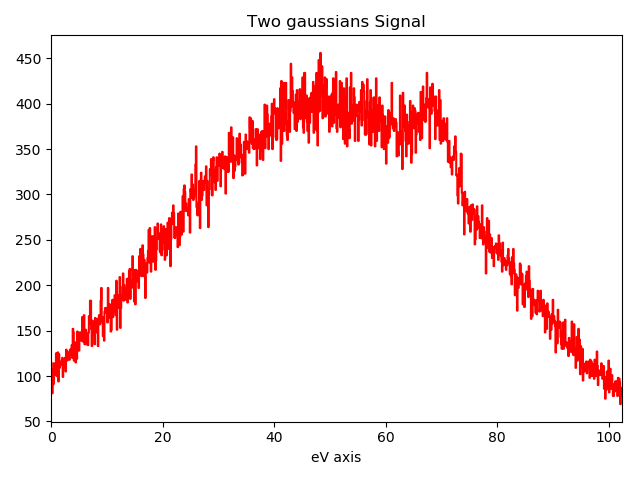

In [6]:
s.plot()

<a id='creating_model'></a>

[[Go to TOC]](#Table-of-Contents)

Creating a model now is simple - just pass the spectrum to the function 
> `model_reference = signal_reference.create_model()`

Let's reference the model by "`m`".

In [7]:
m = s.create_model()

Let's look what's inside:

In [8]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------

As we can see, the model is still empty. That will not always be the case - for some types of signals, an automatic background component is added when creating a model, hence it's always good to check.

We can plot the model in exactly the same way as the signal:

<IPython.core.display.Javascript object>


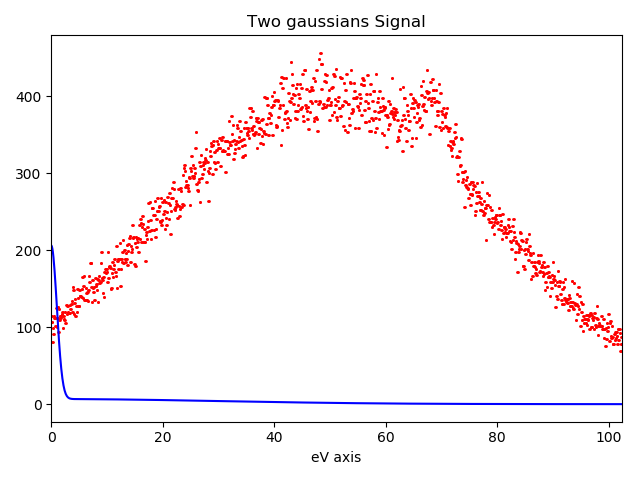

In [12]:
m.plot()

The only difference from the model plot is that each data point is displayed individually. 

<a id='creating_components'></a>

[[Go to TOC]](#Table-of-Contents)


To do anything with the model, we should __create__ some __components__ and add them. Let's create two gaussians, referenced as "g1" and "g2":

-----------------
P.S.: keep in mind that creating a component is a function - hence there should be brackets at the end! Such as 
> `our_component_reference = hs.model.components1D.example_component()`

In [9]:
g1 = hs.model.components1D.Gaussian()
g2 = hs.model.components1D.Gaussian()

<a id='adding_comps'></a>

[[Go to TOC]](#Table-of-Contents)

... and __add the components to__ our __model__. For that there are generally two ways:

Individually
> `our_model_reference.append(our_component_reference)`

or in lists (i.e. grouped by square brackets)
> `our_model_reference.extend([first_component_reference, second_component_reference])`

In [10]:
m.extend([g1, g2])

Let's check how the model looks now:

In [11]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |            Gaussian |            Gaussian |            Gaussian
   1 |          Gaussian_0 |          Gaussian_0 |            Gaussian

<a id='renaming_components'></a>

[[Go to TOC]](#Table-of-Contents)


For our convenience we can __rename__ the __components__ as we choose, for example "large" and "small" (note that the "g1" and "g2" are only references we created for them, not names of the components)

In [12]:
g1.name = "large"
g2.name = "small"

We can look at the model again to see the result

In [13]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |               large |               large |            Gaussian
   1 |               small |               small |            Gaussian

<a id='checking_values'></a>

[[Go to TOC]](#Table-of-Contents)


To finally see the full structure (the one we looked at <a href='#terms'>here</a>), we can __print all of the parameter values__ of all components of the model.

In [14]:
m.print_current_values()

Components	Parameter	Value
large
		A	1
		centre	0
		sigma	1
small
		A	1
		centre	0
		sigma	1


To access the values, we have to look inside the components for the parameters. It can simply be done by following the pattern:
> `some_component_reference.parameter_name.value`

In this case the component references are the __g1__ and __g2__, while parameter names are __centre__, __A__ and __sigma__.

In [15]:
g1.sigma.value

1.0

<a id='setting_values'></a>

[[Go to TOC]](#Table-of-Contents)


We can __set parameter values__ in exactly the same way. Let set `g1` `sigma` value to 30:

In [16]:
g1.sigma.value = 30

In [17]:
m.print_current_values()

Components	Parameter	Value
large
		A	1
		centre	0
		sigma	30
small
		A	1
		centre	0
		sigma	1


For convenience, we can also __set values "in bulk"__ for all components in the model. The required command is
> `m.set_parameters_value`

Set the area ("A" parameter) of both peaks to 500

In [18]:
m.set_parameters_value('A', 500)

In [19]:
m.print_current_values()

Components	Parameter	Value
large
		A	500
		centre	0
		sigma	30
small
		A	500
		centre	0
		sigma	1


<a id='adjust_position'></a>

[[Go to TOC]](#Table-of-Contents)


When using HyperSpy in a notebook (like this one), we can also use additional functions to adjust parameters with a mouse (interactively).

In order to enable it, call __`.notebook_interaction()`__ for either model, component or parameter directly:

<IPython.core.display.Javascript object>


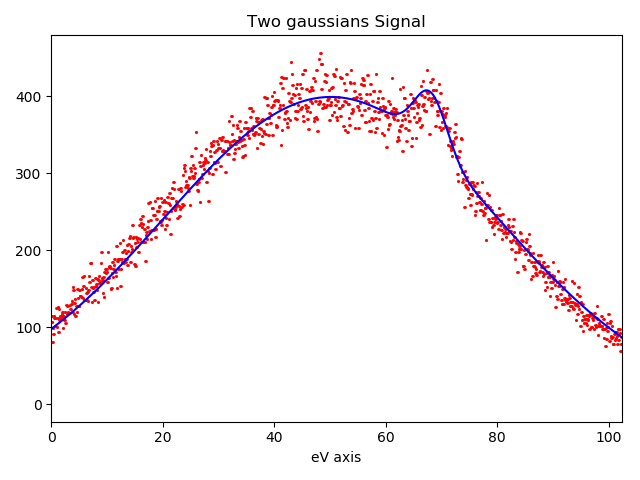

In [20]:
m.plot()

In [29]:
m.enable_plot_components()

In [30]:
m.enable_adjust_position()

In [26]:
m.gui()

Accordion(children=(VBox(children=(Checkbox(value=True, description='active'), HBox(children=(FloatText(value=0.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=500.0, description='A', layout=Layout(flex='1 1 auto', width='auto'), max=510.0, step=0.51), FloatText(value=510.0, description='max', layout=Layout(flex='0 1 auto', width='auto')))), HBox(children=(FloatText(value=20.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=30.0, description='sigma', layout=Layout(flex='1 1 auto', width='auto'), max=40.0, min=20.0, step=0.02), FloatText(value=40.0, description='max', layout=Layout(flex='0 1 auto', width='auto')))), HBox(children=(FloatText(value=0.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=0.0, description='centre', layout=Layout(flex='1 1 auto', width='auto'), max=102.30000000000001), FloatText(value=102.30000000000001, description='max', layout=Layout(flex='0 1 auto', width='auto')))))), VBox(children=(Checkbox(value=True, description='active'), HBox(children=(FloatText(value=0.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=500.0, description='A', layout=Layout(flex='1 1 auto', width='auto'), max=510.0, step=0.51), FloatText(value=510.0, description='max', layout=Layout(flex='0 1 auto', width='auto')))), HBox(children=(FloatText(value=-9.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=1.0, description='sigma', layout=Layout(flex='1 1 auto', width='auto'), max=11.0, min=-9.0, step=0.02), FloatText(value=11.0, description='max', layout=Layout(flex='0 1 auto', width='auto')))), HBox(children=(FloatText(value=0.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=0.0, description='centre', layout=Layout(flex='1 1 auto', width='auto'), max=102.30000000000001), FloatText(value=102.30000000000001, description='max', layout=Layout(flex='0 1 auto', width='auto'))))))), _titles={'0': 'large', '1': 'small'})

In [31]:
m.disable_adjust_position()
m.disable_plot_components()

Finally, let's __fit__ the our __model__ and plot it afterwards to see how well (or poorly) we did

In [27]:
m.fit()

In [33]:
m.print_current_values()

Components	Parameter	Value
large
		A	29887.2
		centre	50.1704
		sigma	29.8957
small
		A	523.231
		centre	68.109
		sigma	2.91281


<a id='multifit'></a>

Fitting multi-dimensional signals
--------------------------------------


When the signal is a collection of spectra (e.g. EELS / EDS), we can fit all of them automatically (sequentially).

First load the spectrum `smoothly_moving_peaks.hspy`, reference  it as `s2` and create a new model for it `m2`:

In [34]:
s2 = hs.load('smoothly_moving_peaks.hspy')
m2 = s2.create_model()

We can still use the two components we had in the previous part ( `g1` and `g2`), so let's just add them to the new model and plot it to see what it looks like:

<IPython.core.display.Javascript object>


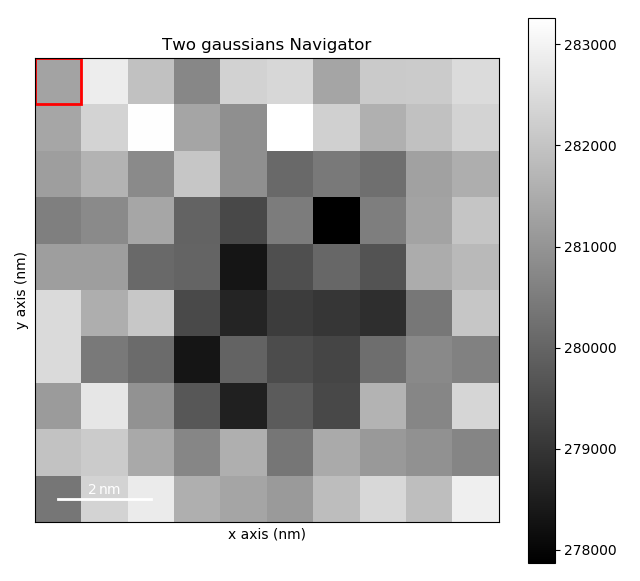

<IPython.core.display.Javascript object>


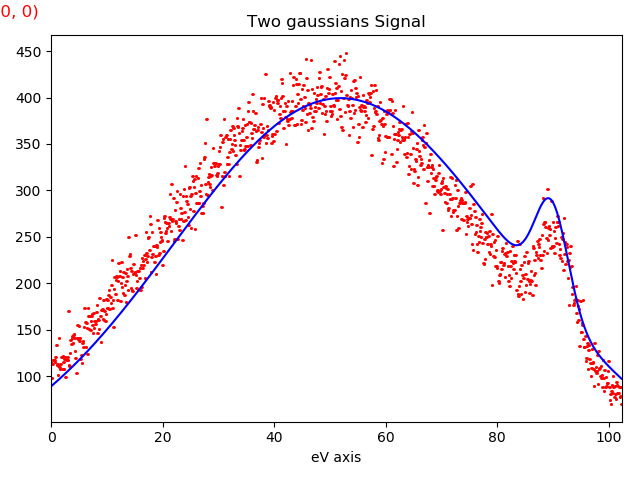

In [35]:
m2.extend([g1,g2])
m2.plot()

We can see that the small peak is not where it should be, so just adjust its position as previously

In [36]:
m2.gui()

Accordion(children=(VBox(children=(Checkbox(value=True, description='active'), HBox(children=(FloatText(value=0.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=29887.197385106607, description='A', layout=Layout(flex='1 1 auto', width='auto'), max=29897.197385106607, step=29.897197385106608), FloatText(value=29897.197385106607, description='max', layout=Layout(flex='0 1 auto', width='auto')))), HBox(children=(FloatText(value=19.89565824543386, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=29.89565824543386, description='sigma', layout=Layout(flex='1 1 auto', width='auto'), max=39.895658245433864, min=19.89565824543386, step=0.020000000000000004), FloatText(value=39.895658245433864, description='max', layout=Layout(flex='0 1 auto', width='auto')))), HBox(children=(FloatText(value=0.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=50.170356060015074, description='centre', layout=Layout(flex='1 1 auto', width='auto'), max=102.30000000000001), FloatText(value=102.30000000000001, description='max', layout=Layout(flex='0 1 auto', width='auto')))))), VBox(children=(Checkbox(value=True, description='active'), HBox(children=(FloatText(value=0.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=523.2309802619474, description='A', layout=Layout(flex='1 1 auto', width='auto'), max=533.2309802619474, step=0.5332309802619474), FloatText(value=533.2309802619474, description='max', layout=Layout(flex='0 1 auto', width='auto')))), HBox(children=(FloatText(value=-7.08718564093351, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=2.9128143590664903, description='sigma', layout=Layout(flex='1 1 auto', width='auto'), max=12.912814359066491, min=-7.08718564093351, step=0.02), FloatText(value=12.912814359066491, description='max', layout=Layout(flex='0 1 auto', width='auto')))), HBox(children=(FloatText(value=0.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=68.10898246040475, description='centre', layout=Layout(flex='1 1 auto', width='auto'), max=102.30000000000001), FloatText(value=102.30000000000001, description='max', layout=Layout(flex='0 1 auto', width='auto'))))))), _titles={'0': 'large', '1': 'small'})

Now we can perform a fit for all of the signals sequentially by passing command
> `m2.multifit()`

Even though it slows HyperSpy down, it is useful (for now!) to have the model plot windows open when the command is passed:

- In the signal widow you can see (however briefly) all of the signals and the corresponding fit
- In the navigator window you can track the order the signals are being fitted. If you end up using this feature often, you'll notice that it has a huge impact on the accuracy of the results if chosen poorly. The next HyperSpy version (1.0) will have an automatic routine "SAMFire" to do that in a smart way, hence enabling much more complex models to be fitted effortlessly.

In [37]:
m2.multifit()

HBox(children=(IntProgress(value=0), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

<a id='plot_components'></a>

[[Go to TOC]](#Table-of-Contents)


We can see the total result of the fit, however it is often useful to see each component individually


<IPython.core.display.Javascript object>


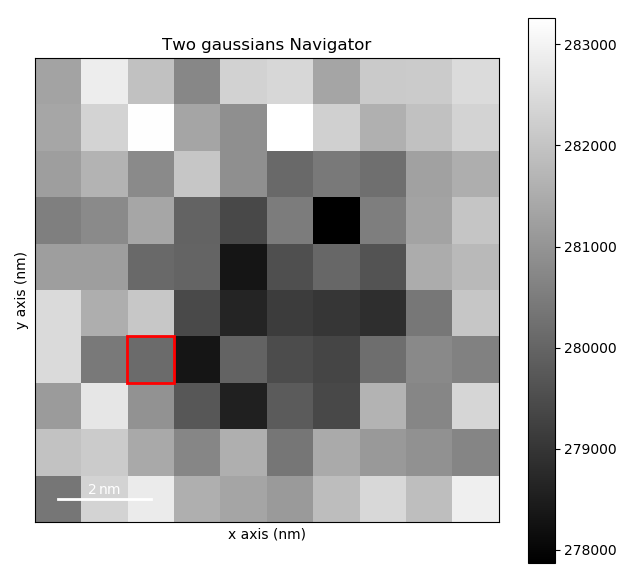

<IPython.core.display.Javascript object>


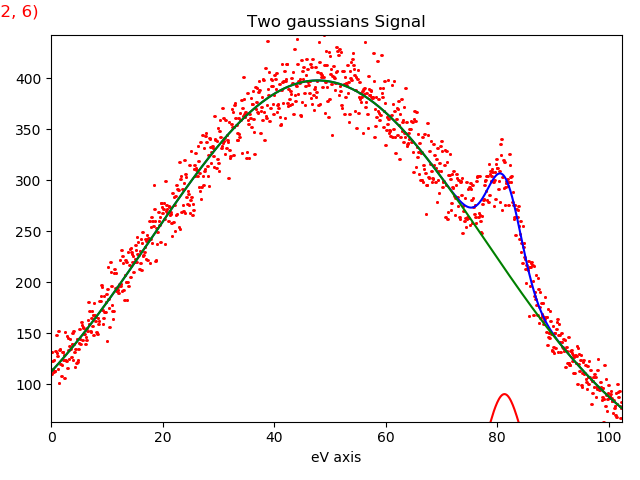

In [38]:
m2.plot(plot_components=True)

<a id='plot_parameter'></a>

[[Go to TOC]](#Table-of-Contents)


Now that we have the artificial spectral image (SI) fitted, we can look at it however we want! For example, when fitting, you might have noticed that the position of the small peak shifted from pixel to pixel. We can __plot__ the centre __parameter__ of the component to have a look at it:

<IPython.core.display.Javascript object>


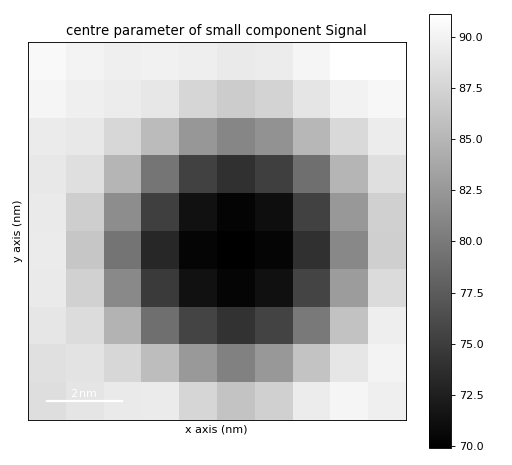

In [39]:
g2.centre.plot()

<a id='statistics'></a>

Goodness of fit
------------------

[[Go to TOC]](#Table-of-Contents)


Once the fit was performed, chi-squared ($\chi^2$), degrees of freedom and reduced chi-squared of the fit are automatically calculated.

They are accessible with, respectively:
> `m2.chisq`

> `m2.dof`

> `m2.red_chisq`

Let's have a look at reduced $\chi^2$ by plotting it

<IPython.core.display.Javascript object>


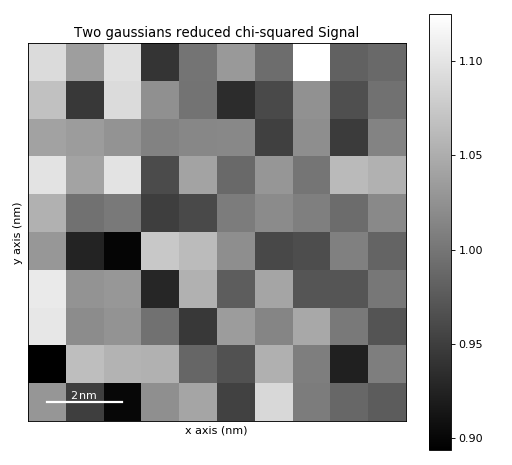

In [40]:
m2.red_chisq.plot()

We can see that the map looks relatively uniform (albeit with some noise, as expected). The colorbar scale tells us that all of the points fall in the (0.9, 1.15) range, which shows a good fit.

We can of course plot the histogram of the same data like so:

<IPython.core.display.Javascript object>


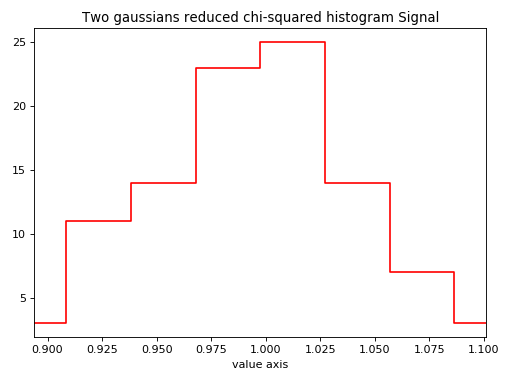

In [41]:
m2.red_chisq.get_histogram().plot()

<a id='expression'></a>

Defining your own components
---------------------------------

[[Go to TOC]](#Table-of-Contents)




Lets say we have a slightly stranger signal that we want to fit, like this one:

In [42]:
s = hs.load('wobbly_peak.hspy')

<IPython.core.display.Javascript object>


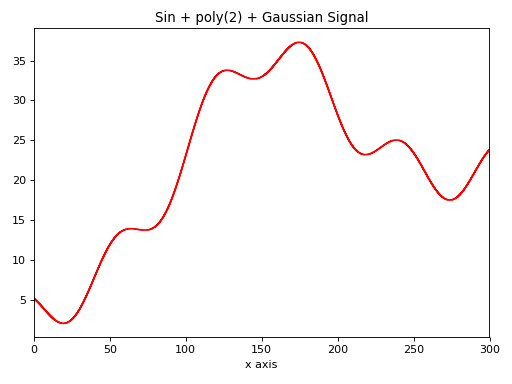

In [43]:
s.plot()

It's (as the name implies) composed of a sinus + gaussian + 2nd degree polynomial. However we don't have a `sin` component in the in-build library, so we'll just write our own:

In [70]:
sin = hs.model.components1D.Expression('A * sin(2*pi / T * (x - x0))',
                                        name='sin',)

In [71]:
sin

<sin (Expression component)>

In [72]:
sin.parameters

(<Parameter A of sin component>,
 <Parameter T of sin component>,
 <Parameter x0 of sin component>)

Then just create and add all the additional components we might need: a gaussian and a polynomial

In [73]:
m = s.create_model()
gaus = hs.model.components1D.GaussianHF()
poly = hs.model.components1D.Polynomial(2)
m.extend([sin, gaus, poly])

In [74]:
m.print_current_values()

Components	Parameter	Value
sin
		A	0
		T	0
		x0	0
GaussianHF
		centre	0
		fwhm	1
		height	1
Polynomial
		coefficients[0]	0
		coefficients[1]	0
		coefficients[2]	0


The initial values do not seem to be very useful, so let's just plot the model, turn on the widgets, and we'll play until things seem close enough:

<IPython.core.display.Javascript object>


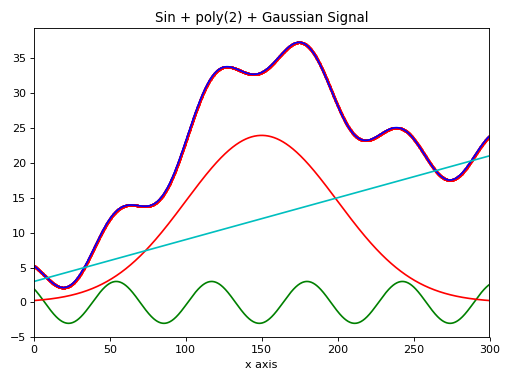

/home/francisco/anaconda/anaconda/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/francisco/anaconda/anaconda/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in true_divide
  """
/home/francisco/anaconda/anaconda/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in sin
  """


Accordion(children=(VBox(children=(Checkbox(value=True, description='active'), HBox(children=(FloatText(value=-10.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=0.0, description='A', layout=Layout(flex='1 1 auto', width='auto'), max=10.0, min=-10.0, step=0.02), FloatText(value=10.0, description='max', layout=Layout(flex='0 1 auto', width='auto')))), HBox(children=(FloatText(value=-10.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=0.0, description='T', layout=Layout(flex='1 1 auto', width='auto'), max=10.0, min=-10.0, step=0.02), FloatText(value=10.0, description='max', layout=Layout(flex='0 1 auto', width='auto')))), HBox(children=(FloatText(value=-10.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=0.0, description='x0', layout=Layout(flex='1 1 auto', width='auto'), max=10.0, min=-10.0, step=0.02), FloatText(value=10.0, description='max', layout=Layout(flex='0 1 auto', width='auto')))))), VBox(children=(Checkbox(value=True, description='active'), HBox(children=(FloatText(value=0.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=0.0, description='centre', layout=Layout(flex='1 1 auto', width='auto'), max=299.90000000000003), FloatText(value=299.90000000000003, description='max', layout=Layout(flex='0 1 auto', width='auto')))), HBox(children=(FloatText(value=0.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=1.0, description='fwhm', layout=Layout(flex='1 1 auto', width='auto'), max=11.0, step=0.011), FloatText(value=11.0, description='max', layout=Layout(flex='0 1 auto', width='auto')))), HBox(children=(FloatText(value=-9.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=1.0, description='height', layout=Layout(flex='1 1 auto', width='auto'), max=11.0, min=-9.0, step=0.02), FloatText(value=11.0, description='max', layout=Layout(flex='0 1 auto', width='auto')))))), VBox(children=(Checkbox(value=True, description='active'), Accordion(children=(VBox(children=(Button(description='Update', style=ButtonStyle(), tooltip='Unlike most other widgets, the multivalue parameter widgets do not update automatically when the value of the changes by other means. Use this button to update the valuesmanually'), HBox(children=(FloatText(value=-10.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=0.0, description='0', layout=Layout(flex='1 1 auto', width='auto'), max=10.0, min=-10.0, step=0.02), FloatText(value=10.0, description='max', layout=Layout(flex='0 1 auto', width='auto')))), HBox(children=(FloatText(value=-10.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=0.0, description='1', layout=Layout(flex='1 1 auto', width='auto'), max=10.0, min=-10.0, step=0.02), FloatText(value=10.0, description='max', layout=Layout(flex='0 1 auto', width='auto')))), HBox(children=(FloatText(value=-10.0, description='min', layout=Layout(flex='0 1 auto', width='auto')), FloatSlider(value=0.0, description='2', layout=Layout(flex='1 1 auto', width='auto'), max=10.0, min=-10.0, step=0.02), FloatText(value=10.0, description='max', layout=Layout(flex='0 1 auto', width='auto')))))),), _titles={'0': 'coefficients'})))), _titles={'0': 'sin', '1': 'GaussianHF', '2': 'Polynomial'})

/home/francisco/anaconda/anaconda/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/francisco/anaconda/anaconda/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in true_divide
  """
/home/francisco/anaconda/anaconda/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in sin
  """


In [75]:
m.plot()

m.gui()

And then fit it and look at the results!

In [77]:
m.fit()

In [78]:
m.enable_plot_components()

In [79]:
m.print_current_values()

Components	Parameter	Value
sin
		A	-3
		T	62.8109
		x0	7.07727
GaussianHF
		centre	149.95
		fwhm	117.702
		height	23.9365
Polynomial
		coefficients[0]	-3.54794e-12
		coefficients[1]	0.06002
		coefficients[2]	3
